In [2]:
import uproot
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
import math
import csv
import math
import seaborn as sns
import sympy as smp
import sympy.stats
from scipy import stats,signal,ndimage,special,fft
from scipy.optimize import curve_fit
from scipy.integrate import quad
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches

Cuts

In [3]:
def truth_cuts(pdg, p, mode):
    nprotons = np.count_nonzero(pdg == 2212)
    nmuons = np.count_nonzero(pdg == 13) + np.count_nonzero(pdg == -13)
    npions = np.count_nonzero(pdg == 111) + np.count_nonzero(pdg == 211) + np.count_nonzero(pdg == -211) 
    #nprotons = 0
    #nmuons = 0
    #npions = 0

    #for part in range(len(pdg)):
    #    if pdg[part] == 2212 and p[part] <= 2.0 and p[part] > 0.1:
    #        nprotons += 1
    #    if pdg[part] == 13 or pdg[part] == -13:
    #        if p[part] <= 10.0 and p[part] >= 0.0:
    #            nmuons += 1
    #    if pdg[part] == 111 or pdg[part] == 211 or pdg[part] == -211:
    #        npions += 1

    if nprotons == 1 and nmuons == 1 and npions == 0 and mode == 1: #QE
        return 1
    else:
        return 0
    
def reco_cuts(pdg, p):
    #nprotons = np.count_nonzero(pdg == 2212)
    #nmuons = np.count_nonzero(pdg == 13) + np.count_nonzero(pdg == -13)
    #npions = np.count_nonzero(pdg == 111) + np.count_nonzero(pdg == 211) + np.count_nonzero(pdg == -211) 
    nprotons = 0
    nmuons = 0
    npions = 0

    for part in range(len(pdg)):
        if pdg[part] == 2212: #and p[part] <= 2.0 and p[part] > 0.1:
            nprotons += 1
        if pdg[part] == 13 or pdg[part] == -13:
            #if p[part] <= 10.0 and p[part] >= 0.0:
            nmuons += 1
        if pdg[part] == 111 or pdg[part] == 211 or pdg[part] == -211:
            npions += 1

    if nprotons == 1 and nmuons == 1 and npions == 0: #QE
        return 1
    else:
        return 0

Purity file

In [4]:
tracks = uproot.open("/nashome/z/zaemoore/2x2_CAF/purity_efficiency/qe_purity_eff_output_1.0.root")
tracks["CafTree"].show()
tracks["CafTree"].keys()

branches = tracks["CafTree"].arrays()[0]
file_index = branches['file_index']
print(np.unique(file_index))

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
reco_energy          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_x             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_y             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_z             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_mag           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_length          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_rot       | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_incl      | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_x         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_y         | std::

Calculate Purity <br>
Purity = Number of True CC1mu2p0pi Events that pass all cuts/Number of events that pass all cuts <br>
Calculate Efficiency <br>
Efficiency = Number of true signal events that pass all cuts/Number of true signal events <br> <br>

Signal means the reconstructed event is the "signal" we are looking for (reco passes the cuts) <br>
True means the truth level event is what we are looking for (truth passes the cuts)

In [5]:
#Arrays to save information
true_signal_event = []
true_event = []
signal_event = []

#For plots (save from reco information)
leading_p_p = []
recoil_p_p = []
theta_pp = []

#Reco and true proton momentum for plots
proton_true_p = []
proton_reco_p = []

#Loop through each file index
for file_idx in np.unique(file_index):
    true_energy = branches['true_energy'][file_index == file_idx]
    true_p_x = branches['true_p_x'][file_index == file_idx]
    true_p_y = branches['true_p_y'][file_index == file_idx]
    true_p_z = branches['true_p_z'][file_index == file_idx]
    true_p_mag = branches['true_p_mag'][file_index == file_idx]
    true_length = branches['true_length'][file_index == file_idx]
    true_angle = branches['true_angle'][file_index == file_idx]
    true_angle_rot = branches['true_angle_rot'][file_index == file_idx]
    true_angle_incl = branches['true_angle_incl'][file_index == file_idx]
    true_angle_x = branches['true_angle_x'][file_index == file_idx]
    true_angle_y = branches['true_angle_y'][file_index == file_idx]
    true_angle_z = branches['true_angle_z'][file_index == file_idx]
    true_vtx_x = branches['true_vtx_x'][file_index == file_idx]
    true_vtx_y = branches['true_vtx_y'][file_index == file_idx]
    true_vtx_z = branches['true_vtx_z'][file_index == file_idx]
    true_track_start_x = branches['true_track_start_x'][file_index == file_idx]
    true_track_start_y = branches['true_track_start_y'][file_index == file_idx]
    true_track_start_z = branches['true_track_start_z'][file_index == file_idx]
    true_track_end_x = branches['true_track_end_x'][file_index == file_idx]
    true_track_end_y = branches['true_track_end_y'][file_index == file_idx]
    true_track_end_z = branches['true_track_end_z'][file_index == file_idx]
    true_pdg = branches['true_pdg'][file_index == file_idx]
    true_nproton = branches['true_nproton'][file_index == file_idx]
    mode = branches['mode'][file_index == file_idx]

    reco_energy = branches['reco_energy'][file_index == file_idx]
    reco_p_x = branches['reco_p_x'][file_index == file_idx]
    reco_p_y = branches['reco_p_y'][file_index == file_idx]
    reco_p_z = branches['reco_p_z'][file_index == file_idx]
    reco_p_mag = branches['reco_p_mag'][file_index == file_idx]
    reco_length = branches['reco_length'][file_index == file_idx]
    reco_angle = branches['reco_angle'][file_index == file_idx]
    reco_angle_rot = branches['reco_angle_rot'][file_index == file_idx]
    reco_angle_incl = branches['reco_angle_incl'][file_index == file_idx]
    reco_angle_x = branches['reco_angle_x'][file_index == file_idx]
    reco_angle_y = branches['reco_angle_y'][file_index == file_idx]
    reco_angly_z = branches['reco_angle_z'][file_index == file_idx]
    reco_vtx_x = branches['reco_vtx_x'][file_index == file_idx]
    reco_vtx_y = branches['reco_vtx_y'][file_index == file_idx]
    reco_vtx_z = branches['reco_vtx_z'][file_index == file_idx]
    reco_track_start_x = branches['reco_track_start_x'][file_index == file_idx]
    reco_track_start_y = branches['reco_track_start_y'][file_index == file_idx]
    reco_track_start_z = branches['reco_track_start_z'][file_index == file_idx]
    reco_track_end_x = branches['reco_track_end_x'][file_index == file_idx]
    reco_track_end_y = branches['reco_track_end_y'][file_index == file_idx]
    reco_track_end_z = branches['reco_track_end_z'][file_index == file_idx]
    reco_pdg = branches['reco_pdg'][file_index == file_idx]
    reco_ixn_index = branches['reco_ixn_index'][file_index == file_idx]
    spill_index = branches['spill_index'][file_index == file_idx]
    event = branches['event'][file_index == file_idx]
    subrun = branches['subrun'][file_index == file_idx]
    caf_file_name = branches['caf_file_name'][file_index == file_idx]

    #Loop through each event in the file
    for ev in np.unique(event):

        reco_passes = 0
        truth_passes = 0

        reco_passes = reco_cuts(reco_pdg[event == ev], reco_p_mag[event == ev])
        truth_passes = truth_cuts(true_pdg[event == ev], true_p_mag[event == ev], mode[event == ev][0])

        signal_event.append(reco_passes)
        true_event.append(truth_passes)

        if reco_passes == 1 and truth_passes == 1:
            true_signal_event.append(1)
        else:
            true_signal_event.append(0)
        
        #Save proton momentum information for plots
        proton_p_reco = reco_p_mag[event == ev][reco_pdg[event == ev] == 2212]
        proton_p_truth = true_p_mag[event == ev][true_pdg[event == ev] == 2212]

        proton_reco_p.extend(proton_p_reco)
        proton_true_p.extend(proton_p_truth)

        #Find max (lead) and min (recoil) protons
        #Some events may be true CC2p1mu0pi, but the reconstruction may not see any protons
        #We need to account for these events that have no proton momentum
        if len(proton_p_reco) == 0:
            leading_p_p.append(0)
            recoil_p_p.append(0)
        else:
            leading_p_p.append(max(proton_p_reco))
            recoil_p_p.append(min(proton_p_reco))

        #Save angle between protons for plots FOR LATER


purity = sum(true_signal_event)/sum(signal_event)
print("Purity measurement: ", purity)

efficiency = sum(true_signal_event)/sum(true_event)
print("Efficiency measurement: ", efficiency)

Purity measurement:  0.20906801007556675
Efficiency measurement:  1.0


Purity and efficiency plots

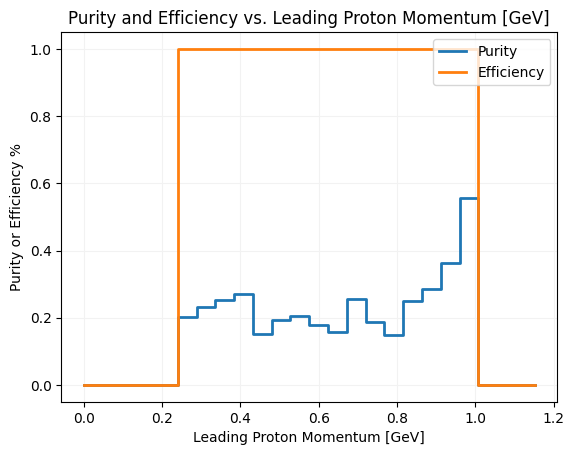

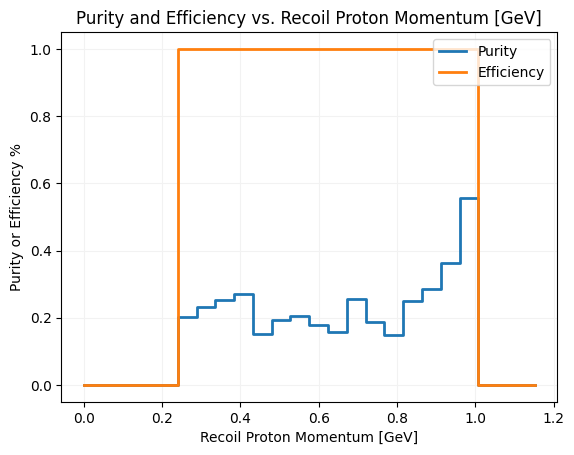

      signal  true  true and signal  leading proton p  recoil proton p  \
0          1     0                0          0.308910         0.308910   
1          1     1                1          0.323805         0.323805   
2          1     0                0          0.712970         0.712970   
3          1     0                0          0.476173         0.476173   
4          1     0                0          0.867089         0.867089   
...      ...   ...              ...               ...              ...   
1199       1     0                0          0.355929         0.355929   
1200       1     1                1          0.611483         0.611483   
1201       1     0                0          0.628644         0.628644   
1202       1     1                1          0.243705         0.243705   
1203       1     1                1          0.474941         0.474941   

     bin lpp bin rpp  
0          6       6  
1          6       6  
2         14      14  
3          9       

In [6]:
data = {'signal': signal_event, 'true': true_event, 'true and signal': true_signal_event, 'leading proton p': leading_p_p, 'recoil proton p': recoil_p_p}
df = pd.DataFrame(data=data)

purity_vals_lpp = []
purity_vals_rpp = []
eff_vals_lpp = []
eff_vals_rpp = []

#Leading proton momentum binning
nbins_lpp = 25
hist_lpp, bin_edges_lpp = np.histogram(leading_p_p, bins=nbins_lpp, range=(0,1.2)) #Create bins based on leading proton momentum
labels_lpp = np.arange(0, nbins_lpp) #Label each bin numerically for leading proton momentum

df['bin lpp'] = pd.cut(df['leading proton p'], bins=bin_edges_lpp, labels=labels_lpp) #Create a column in df defining the number bin each event is in based on leading proton momentum

#Repeat proton momentum binning
nbins_rpp = 25
hist_rpp, bin_edges_rpp = np.histogram(recoil_p_p, bins=nbins_rpp, range=(0,1.2)) #Create bins based on recoil proton momentum
labels_rpp = np.arange(0, nbins_rpp) #Label each bin numerically for recoil proton momentum

df['bin rpp'] = pd.cut(df['recoil proton p'], bins=bin_edges_rpp, labels=labels_rpp) #Create a column in df defining the number bin each event is in based on recoil proton momentum

#efficiency = sum(true_signal_event)/sum(true_event)
#Loop through each leading proton momentum bin and calculate purity & efficiency
for i in labels_lpp:
    df_bin = df[(df['bin lpp'] == i)]

    signal_bin = np.array(df_bin['signal'])
    true_signal_bin = np.array(df_bin['true and signal'])
    true_bin = np.array(df_bin['true'])

    if sum(signal_bin) == 0:
        purity_vals_lpp.append(0)
    else:
        purity_vals_lpp.append(sum(true_signal_bin)/sum(signal_bin))
    
    if sum(true_bin) == 0:
        eff_vals_lpp.append(0)
    else:
        eff_vals_lpp.append(sum(true_signal_bin)/sum(true_bin))

#Loop through each recoil proton momentum bin and calculate purity & efficiency
for i in labels_rpp:
    df_bin = df[(df['bin rpp'] == i)]

    signal_bin = np.array(df_bin['signal'])
    true_signal_bin = np.array(df_bin['true and signal'])
    true_bin = np.array(df_bin['true'])

    if sum(signal_bin) == 0:
        purity_vals_rpp.append(0)
    else:
        purity_vals_rpp.append(sum(true_signal_bin)/sum(signal_bin))

    if sum(true_bin) == 0:
        eff_vals_rpp.append(0)
    else:
        eff_vals_rpp.append(sum(true_signal_bin)/sum(true_bin))

#Plot purity and efficiency vs. leading proton momentum
#Delete the last bin value because we are plotting each step from the leftmost bin edge
plt.step(np.delete(bin_edges_lpp, nbins_lpp), purity_vals_lpp, where='post', label='Purity', linewidth='2')
plt.step(np.delete(bin_edges_lpp, nbins_lpp), eff_vals_lpp, where='post', label='Efficiency', linewidth='2')
plt.xlabel('Leading Proton Momentum [GeV]')
plt.ylabel('Purity or Efficiency %')
plt.title('Purity and Efficiency vs. Leading Proton Momentum [GeV]')
plt.grid(color='0.95')
plt.legend(loc='upper right')
plt.show()

#Plot purity and efficiency vs. recoil proton momentum
plt.step(np.delete(bin_edges_rpp, nbins_rpp), purity_vals_rpp, where='post', label='Purity', linewidth='2')
plt.step(np.delete(bin_edges_rpp, nbins_rpp), eff_vals_rpp, where='post', label='Efficiency', linewidth='2')
plt.xlabel('Recoil Proton Momentum [GeV]')
plt.ylabel('Purity or Efficiency %')
plt.title('Purity and Efficiency vs. Recoil Proton Momentum [GeV]')
plt.grid(color='0.95')
plt.legend(loc='upper right')
plt.show()

print(df)

Proton truth and reco momentum plots

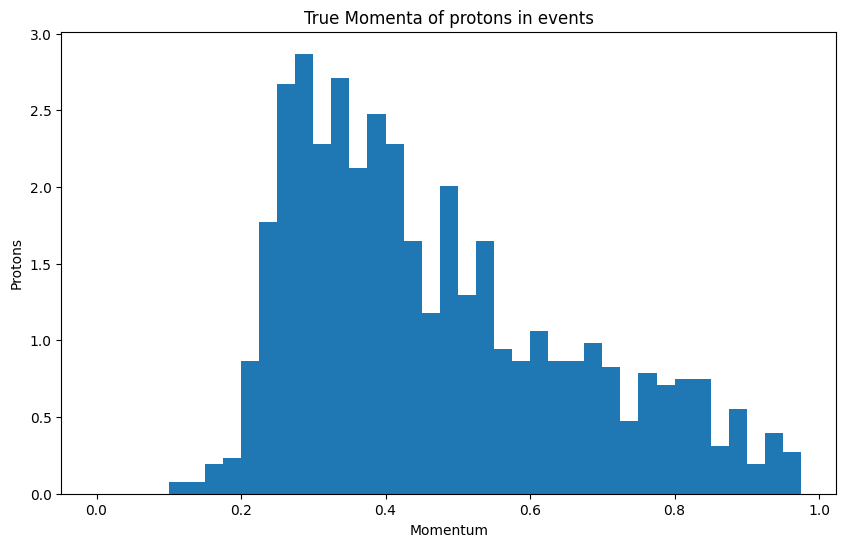

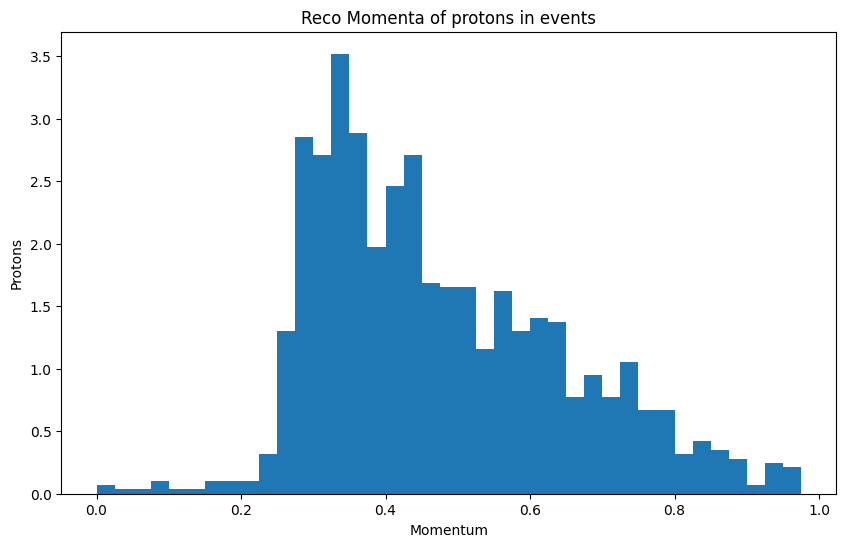

In [7]:
#Split into lead and recoil?

fig = plt.figure(figsize=(10,6))
n, bins, edges = plt.hist(proton_true_p, bins=np.arange(0.0, 1.0, 0.025), density=True)
plt.xticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel("Momentum")
plt.ylabel("Protons")
plt.title("True Momenta of protons in events")
plt.show()

fig = plt.figure(figsize=(10,6))
n, bins, edges = plt.hist(proton_reco_p, bins=np.arange(0.0, 1.0, 0.025), density=True)
plt.xticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel("Momentum")
plt.ylabel("Protons")
plt.title("Reco Momenta of protons in events")
plt.show()